In [99]:
import argparse
import glob
from pathlib import Path
import pickle
import pandas as pd
import string

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from mist.utils.plot_utils import *

from typing import List, Tuple

In [100]:
version = 2

In [101]:
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans serif")
sns.set_context("paper", font_scale=1.3)

width = 7
height = width / 1.618

cmap = plt.cm.get_cmap("tab10")
num_colors = cmap.N
model_colors = {
    "MIST public": mcolors.to_hex(cmap(0)),
    "MIST retrain": mcolors.to_hex(cmap(1 / num_colors)),
    "MIST full": mcolors.to_hex(cmap(2 / num_colors)),
    "CSI:FingerID": mcolors.to_hex(cmap(3 / num_colors)),
}
dist_styles = {
    "Cosine": ":",
    "Bayes": "--",
    "Contrastive": "-",
}

/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_58570/3411518028.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-white", "seaborn-paper"])
/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_58570/3411518028.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-white", "seaborn-paper"])
/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_58570/3411518028.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be r

In [102]:
def plot_retrieval_accuracy(
    retrieval_files, model_names, dist_names, models_to_plot, save_name
):
    save_dir = Path(save_name).parent
    save_dir.mkdir(exist_ok=True)

    assert len(retrieval_files) == len(dist_names)

    # Extract rankings from file
    ret_names, ret_inds = [], []
    for i in retrieval_files:
        with open(i, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            ret_names.append(names)
            ret_inds.append(ind_found)

    # Calc common inds and subset
    common_inds = None
    for i, j in zip(ret_names, ret_inds):
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    new_names, new_inds = [], []
    for ret_name, ret_ind in zip(ret_names, ret_inds):
        mask = [i in common_inds for i in ret_name]
        new_names.append(ret_name[mask])
        new_inds.append(ret_ind[mask])
    ret_inds = new_inds
    ret_names = new_names

    # Create top k
    k_vals = np.arange(0, 1001)
    # max_k = np.max(k_vals) + 1
    top_k_x, top_k_y = [], []
    for ret_ind in ret_inds:
        new_x, new_y = [], []
        for k in k_vals:
            new_x.append(k)
            new_y.append(np.mean(ret_ind <= k))
        top_k_x.append(new_x), top_k_y.append(new_y)
    top_k_x, top_k_y = np.array(top_k_x), np.array(top_k_y)

    # Plot
    cmap = plt.cm.get_cmap("tab10")
    num_colors = cmap.N
    model_colors = {
        "MIST public": mcolors.to_hex(cmap(0)),
        "MIST retrain": mcolors.to_hex(cmap(1 / num_colors)),
        "MIST full": mcolors.to_hex(cmap(2 / num_colors)),
        "CSI:FingerID": mcolors.to_hex(cmap(3 / num_colors)),
    }
    dist_styles = {
        "Cosine": ":",
        "Bayes": "--",
        "Contrastive": "-",
    }

    fig, axes = plt.subplots(
        1, len(models_to_plot), figsize=(width * 2.2, height)
    )

    for i, ((m_idx, lim), ax) in enumerate(zip(models_to_plot, axes)):
        for x, y, model, dist in zip(
            top_k_x[m_idx],
            top_k_y[m_idx],
            model_names[m_idx],
            dist_names[m_idx],
        ):
            color, style = model_colors[model], dist_styles[dist]
            ax.step(
                x[0:],
                y[0:],
                c=color,
                linestyle=style,
                label=f"{model} - {dist}",
            )
        ax.set_box_aspect(1)
        ax.set_xlim([0, lim])
        ax.set_ylim([0, 1])
        ax.set_xlabel("Top k")

        ax.text(
            -0.1,
            1.1,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=15,
            weight="bold",
        )

    axes[0].set_ylabel("Accuracy")

    # Build legend
    patch_legend_handles = [
        Patch(facecolor=model_colors[model], label=model)
        for model in set(model_names)
    ]
    patch_legend_handles.append(
        Rectangle((0, 0), 1, 1, fill=False, edgecolor="none", visible=False)
    )

    patch_legend_handles.insert(
        0,
        Rectangle(
            (0, 0),
            1,
            1,
            fill=False,
            edgecolor="none",
            visible=False,
            label="Model",
        ),
    )
    line_legend_handles = [
        Line2D(
            [0, 1],
            [0, 1],
            linestyle=dist_styles[dist],
            linewidth=0.8,
            color="black",
            label=dist,
        )
        for dist in set(dist_names)
    ]
    line_legend_handles.insert(
        0,
        Rectangle(
            (0, 0),
            1,
            1,
            fill=False,
            edgecolor="none",
            visible=False,
            label="Distance",
        ),
    )
    legend_handles = [*patch_legend_handles, *line_legend_handles]

    legend = ax.legend(
        handles=legend_handles,
        loc="lower right",  # (0.1,0.0),
        frameon=False,
        facecolor="none",
        fancybox=False,  # ncol=2,
        columnspacing=0.5,
    )

    # set_size(*ax_figsize)
    fig.savefig(
        save_name, format="pdf", bbox_inches="tight", dpi=400, transparent=True
    )

/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_58570/320625672.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


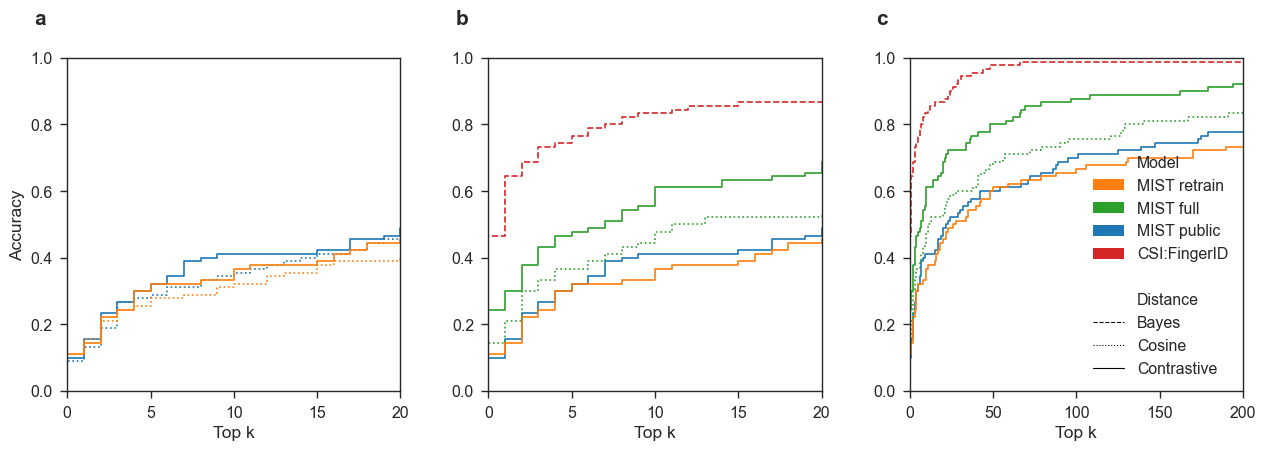

In [103]:
retrieval_files = [
    "../../pretrained_models/mist_canopus_public/fp_model/retrieval_casmi2022/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_casmi2022_cosine_1_ind_found.p",
    "../../pretrained_models/mist_canopus_public/contrastive_model/retrieval_casmi2022/retrieval_avged_0_3_ind_found.p",
    "../../results/retrained_models/mist_fp_model_aug/retrieval_casmi2022/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_casmi2022_cosine_0_ind_found.p",
    "../../results/retrained_models/contrast_model_aug/retrieval_casmi2022/retrieval_avged_0_3_ind_found.p",
    "../../pretrained_models/mist_full/fp_model/retrieval_casmi2022/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_casmi2022_cosine_1_ind_found.p",
    "../../pretrained_models/mist_full/contrastive_model/retrieval_casmi2022/retrieval_avged_0_3_ind_found.p",
    "../../data/paired_spectra/casmi2022/prev_results/csi_ind_found.p",
]
save_name = f"../../results/reusability/retrieval_lineplots/top_k_retrieval_casmi2022_v{version}.pdf"

model_names = np.array(
    [
        "MIST public",
        "MIST public",
        "MIST retrain",
        "MIST retrain",
        "MIST full",
        "MIST full",
        "CSI:FingerID",
    ]
)
dist_names = np.array(
    [
        "Cosine",
        "Contrastive",
        "Cosine",
        "Contrastive",
        "Cosine",
        "Contrastive",
        "Bayes",
    ]
)
# tuples of (model indices, k limit)
models_to_plot = [
    ([0, 1, 2, 3], 20),
    ([1, 3, 4, 5, 6], 20),
    ([1, 3, 4, 5, 6], 200),
]

plot_retrieval_accuracy(
    retrieval_files, model_names, dist_names, models_to_plot, save_name
)

In [104]:
def top_k_retrieval(
    retrieval_files: List[str],
    model_names: List[str],
    dist_names: List[str],
    models_to_plot: Tuple[List[int], int],
    max_k=200,
):
    # Extract rankings from file
    ret_names, ret_inds = [], []
    for i in retrieval_files:
        with open(i, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            ret_names.append(names)
            ret_inds.append(ind_found)

    # Calc common inds and subset
    common_inds = None
    for i, j in zip(ret_names, ret_inds):
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    new_names, new_inds = [], []
    for ret_name, ret_ind in zip(ret_names, ret_inds):
        mask = [i in common_inds for i in ret_name]
        new_names.append(ret_name[mask])
        new_inds.append(ret_ind[mask])
    ret_inds = new_inds
    ret_names = new_names

    # Create top k
    k_vals = np.arange(0, 1001)
    # max_k = np.max(k_vals) + 1
    top_k_x, top_k_y = [], []
    for ret_ind in ret_inds:
        new_x, new_y = [], []
        for k in k_vals:
            new_x.append(k)
            new_y.append(np.mean(ret_ind <= k))
        top_k_x.append(new_x), top_k_y.append(new_y)
    top_k_x, top_k_y = np.array(top_k_x), np.array(top_k_y)

    # to dataframe considering models to plot
    df = pd.DataFrame(
        columns=["plot_id", "model_dist", "k", "accuracy", "model", "dist"]
    )
    for plot_id, (m_idx, lim) in enumerate(models_to_plot):
        for i in m_idx:
            for k, acc in zip(top_k_x[i][:lim], top_k_y[i][:lim]):
                new_row = {
                    "plot_id": plot_id,
                    "model_dist": (model_names[i], dist_names[i]),
                    "k": k,
                    "accuracy": acc,
                    "model": model_names[i],
                    "dist": dist_names[i],
                }
                df = pd.concat(
                    [df, pd.DataFrame([new_row])], ignore_index=True
                )
    print(len(df))
    print(df.head())

    return df

In [105]:
top_k_r = top_k_retrieval(
    retrieval_files, model_names, dist_names, models_to_plot, max_k=200
)
top_k_r.to_csv(
    f"../../results/reusability/top_k_retrieval_casmi2022_df_v{version}.tsv",
    sep="\t",
    index=False,
)
# list(zip(model_names, dist_names))

1180
  plot_id             model_dist  k  accuracy        model    dist
0       0  (MIST public, Cosine)  0  0.000000  MIST public  Cosine
1       0  (MIST public, Cosine)  1  0.088889  MIST public  Cosine
2       0  (MIST public, Cosine)  2  0.133333  MIST public  Cosine
3       0  (MIST public, Cosine)  3  0.188889  MIST public  Cosine
4       0  (MIST public, Cosine)  4  0.266667  MIST public  Cosine


In [106]:
def top_k_ablation(
    retrieval_files: List[str],
    max_k=200,
):

    # Extract rankings from file
    ret_results = {}
    for file in retrieval_files:
        with open(file, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            seed = file.split("/")[4].replace("ablation_retrieval", "")
            model = file.split("/")[5].replace("contrast_", "")
            ret_results[(model, seed)] = (names, ind_found)
    print(len(ret_results))

    # Calc common inds and subset
    common_inds = None
    for i, j in ret_results.values():
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    results_masked = {}
    for key, (ret_name, ret_ind) in ret_results.items():
        mask = [i in common_inds for i in ret_name]
        results_masked[key] = (ret_name[mask], ret_ind[mask])
    ret_results = results_masked

    # Create top k
    top_k_results = {}
    k_vals = np.arange(0, max_k)
    # max_k = np.max(k_vals) + 1
    for key, (ret_name, ret_ind) in ret_results.items():
        top_k_x, top_k_y = [], []
        for k in k_vals:
            top_k_x.append(k)
            top_k_y.append(np.mean(ret_ind <= k))
        top_k_results[key] = (np.array(top_k_x), np.array(top_k_y))

    return top_k_results

In [107]:
ablation_files = glob.glob(
    "../../results/ablation/ablation_models*/**/merged_retrieval/*ind_found.p"
)

# boxplot at k=5 and k=20
k_values = [5, 20]
top_k_abl = top_k_ablation(ablation_files, max_k=20)
print(len(list(top_k_abl.values())))
ablation_models = list(set([i[0] for i in list(top_k_abl.keys())]))
top_k_values = {}
for model in ablation_models:
    for key, (x, y) in top_k_abl.items():
        if key[0] == model:
            for k in k_values:
                if (model, k) not in top_k_values:
                    top_k_values[(model, k)] = [y[k - 1]]
                else:
                    top_k_values[(model, k)].append(y[k - 1])

for k, v in top_k_values.items():
    print(k, np.mean(v), np.std(v))

# to dataframe
box_data = pd.DataFrame(columns=["model", "k", "accuracy"])
for (model, k), acc in top_k_values.items():
    for a in acc:
        new_row = {
            "model": model,
            "k": k,
            "accuracy": a,
        }
        box_data = pd.concat(
            [box_data, pd.DataFrame([new_row])], ignore_index=True
        )
box_data.to_csv(
    f"../../results/reusability/ablation_casmi2022_df_v{version}.tsv",
    sep="\t",
    index=False,
)

25
25
('simulated', 5) 0.26142857142857145 0.0194831167099798
('simulated', 20) 0.45999999999999996 0.027701027756664727
('unfolding', 5) 0.2257142857142857 0.013997084244475301
('unfolding', 20) 0.44000000000000006 0.016035674514745458
('pairwise', 5) 0.21714285714285714 0.03901857223927903
('pairwise', 20) 0.4171428571428571 0.03953815000885156
('magma', 5) 0.21857142857142858 0.016659862556700853
('magma', 20) 0.42142857142857143 0.013552618543578763
('full', 5) 0.22857142857142856 0.02784798384231132
('full', 20) 0.4128571428571428 0.026496052844273428


In [108]:
# Taken from https://stackoverflow.com/a/47664533
class SeabornFig2Grid:

    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(
            self.sg, sns.axisgrid.PairGrid
        ):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """Move PairGrid or Facetgrid"""
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            n, m, subplot_spec=self.subplot
        )
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """Move Jointgrid"""
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            r + 1, r + 1, subplot_spec=self.subplot
        )

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

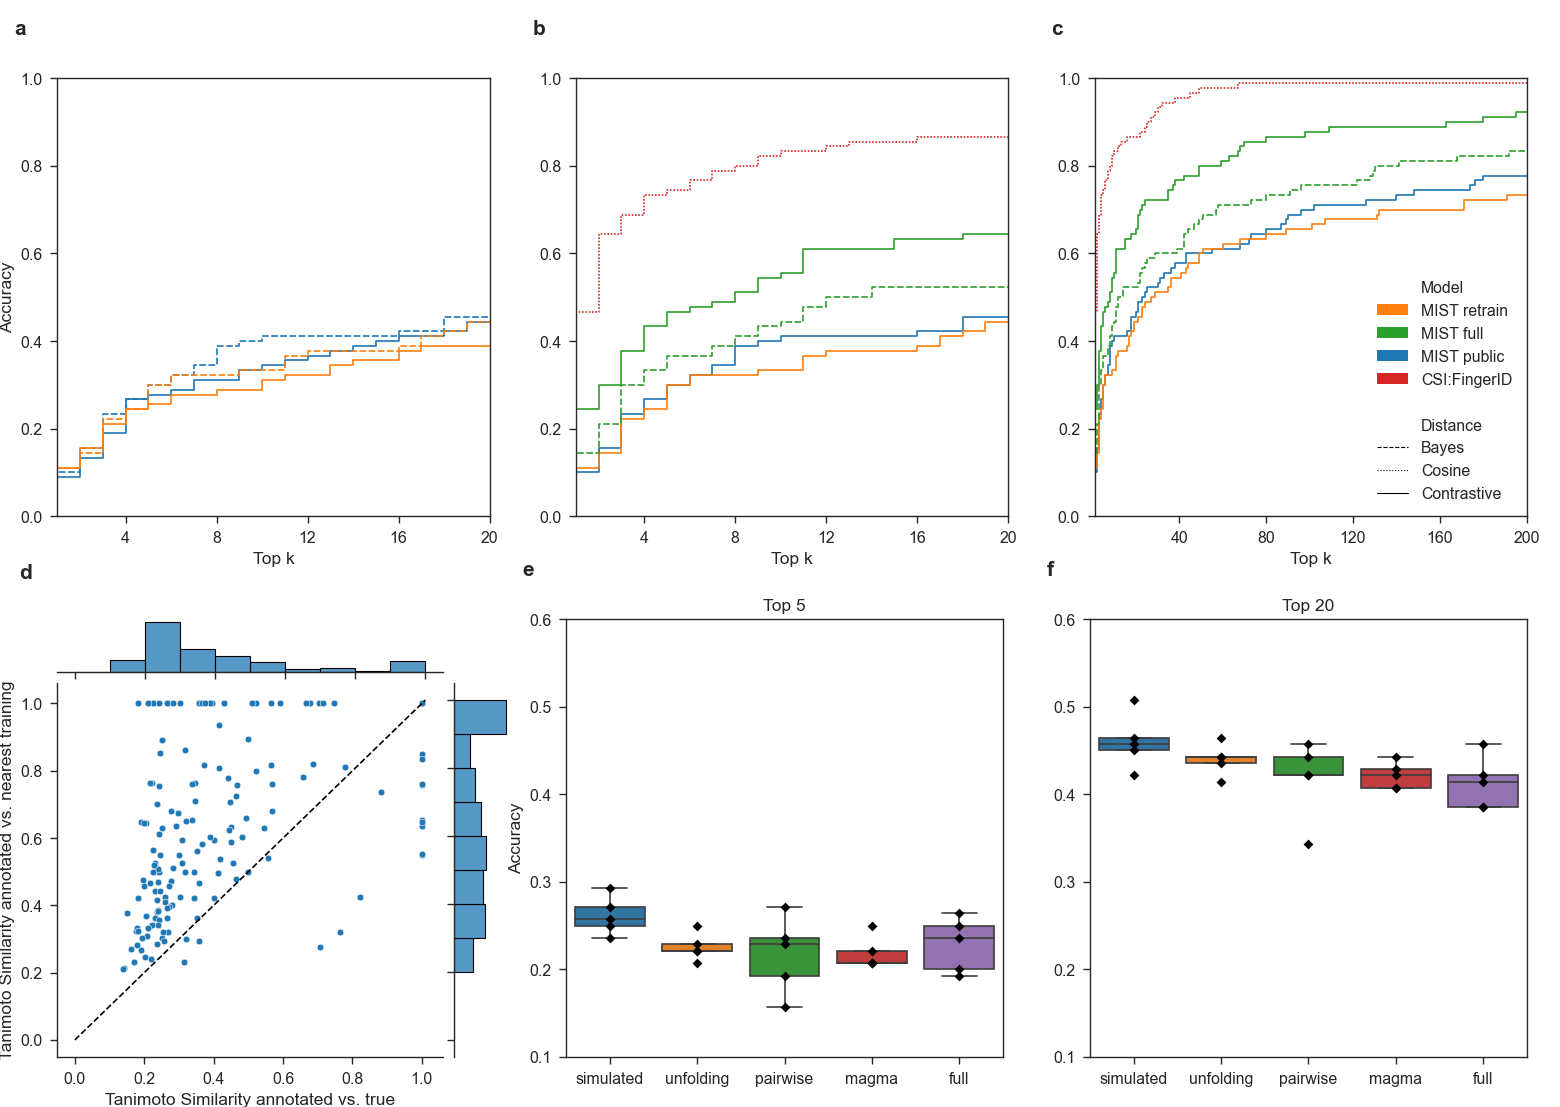

In [109]:
# step plots
step_data = pd.read_csv(
    f"../../results/reusability/top_k_retrieval_casmi2022_df_v2.tsv", sep="\t"
)
step_data["plot_id"] = step_data["plot_id"].astype(int)
step_data["k"] = step_data["k"].astype(int) + 1
step_data["line_color"] = step_data["model"].apply(
    lambda x: model_colors.get(x)
)
step_data["line_style"] = step_data["dist"].apply(lambda x: dist_styles.get(x))

g1 = sns.FacetGrid(step_data, col="plot_id", sharex=False, sharey=False)
g1.map_dataframe(
    sns.lineplot,
    "k",
    "accuracy",
    drawstyle="steps-pre",
    hue="line_color",
    style="line_style",
)
g1.set_titles("")
g1.set(ylim=(0, 1))

step_axes = g1.axes.flat
for i, ax in enumerate(step_axes):
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.set_xlabel("Top k")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.text(
        -0.1,
        1.1,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=15,
        weight="bold",
    )
step_axes[0].set_ylabel("Accuracy")
step_axes[0].set_xlim(1, 20)
step_axes[1].set_xlim(1, 20)
step_axes[2].set_xlim(1, 200)


# Build legend
patch_legend_handles = [
    Patch(facecolor=model_colors[model], label=model)
    for model in set(model_names)
]
patch_legend_handles.append(
    Rectangle((0, 0), 1, 1, fill=False, edgecolor="none", visible=False)
)

patch_legend_handles.insert(
    0,
    Rectangle(
        (0, 0),
        1,
        1,
        fill=False,
        edgecolor="none",
        visible=False,
        label="Model",
    ),
)
line_legend_handles = [
    Line2D(
        [0, 1],
        [0, 1],
        linestyle=dist_styles[dist],
        linewidth=0.8,
        color="black",
        label=dist,
    )
    for dist in set(dist_names)
]
line_legend_handles.insert(
    0,
    Rectangle(
        (0, 0),
        1,
        1,
        fill=False,
        edgecolor="none",
        visible=False,
        label="Distance",
    ),
)
legend_handles = [*patch_legend_handles, *line_legend_handles]

legend = ax.legend(
    handles=legend_handles,
    loc="lower right",  # (0.1,0.0),
    frameon=False,
    facecolor="none",
    fancybox=False,  # ncol=2,
    columnspacing=0.5,
)


# scatter plot
scatter_data = pd.read_csv(
    "../../results/casmi_fp_analysis/casmi_mols.tsv", sep="\t"
)
g2 = sns.jointplot(
    data=scatter_data,
    x="pred_true_similarity",
    y="pred_train_similarity",
    kind="scatter",
    # hue="Superclass",
    marginal_kws=dict(bins=np.arange(0, 1.01, 0.1)),
)
g2.ax_joint.plot([0, 1.01], [0, 1.01], "k--")
# set labels
g2.ax_joint.set_xlabel("Tanimoto Similarity annotated vs. true")
g2.ax_joint.set_ylabel("Tanimoto Similarity annotated vs. nearest training")
g2.ax_joint.text(
    -0.1,
    1.28,
    string.ascii_lowercase[3],
    transform=g2.ax_joint.transAxes,
    size=15,
    weight="bold",
)


# box plots
box_data = pd.read_csv(
    f"../../results/reusability/ablation_casmi2022_df_v2.tsv",
    sep="\t",
)

g3 = sns.FacetGrid(box_data, col="k", sharey=False)
g3.map_dataframe(
    sns.boxplot,
    x="model",
    y="accuracy",
    orient="v",
    showfliers=False,
    palette="tab10",
)
g3.map_dataframe(
    sns.stripplot,
    x="model",
    y="accuracy",
    jitter=False,
    color="black",
    marker="D",
)
g3.set_titles("")
g3.set(ylim=(0.1, 0.6))
g3.set(xlabel=None)

box_axes = g3.axes.flat
for i, ax in enumerate(box_axes):
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.text(
        -0.1,
        1.1,
        string.ascii_lowercase[i + 4],
        transform=ax.transAxes,
        size=15,
        weight="bold",
    )
box_axes[0].set_ylabel("Accuracy")
box_axes[0].set_title("Top 5")
box_axes[1].set_title("Top 20")

fig = plt.figure(figsize=(width * 2.2, height * 2.5))
gs = gridspec.GridSpec(2, 3)

mg0 = SeabornFig2Grid(g1, fig, gs[0, :])
mg1 = SeabornFig2Grid(g2, fig, gs[1, 0])
mg2 = SeabornFig2Grid(g3, fig, gs[1, 1:])

gs.tight_layout(fig, pad=0)
fig.savefig(
    f"../../results/reusability/retrieval_scatter_boxplot_casmi2022_v{version}.pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)